In [1]:
import json
import pandas as pd
from sklearn import preprocessing
import numpy as np
import cv2
from torchvision.io import read_image
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.path as mplpath
import torch.utils.data as data_utils
import matplotlib.patches as patches
from pathlib import Path

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
def data(file_dir_path):
    
    """
    iterates a json-list of image info and returns format
    [ [ [bounding box], is_chinese, symbol, height, width], ... ]
    
    structure of nested lists are: 
    list of images = [[[ [bb], symbol, height, width    ], [bb, symbol ]], [], []]
    
    """
    with open(file_dir_path) as j_file:
        list_of_marks = [] 
        json_list = list(j_file)
        p = 0 
        final = {}
        for json_str in json_list:
            if p > 50: #for relavative batch, for testing
                return final #, list_of_marks
            img = json.loads(json_str)
            img_id = img['image_id']+'.jpg'
            l_poly = []
            
            for key, value in img.items():
                for v in img['annotations']: #all annotations per image

                    for dic in v:
                        if dic['is_chinese']:
                           # print(dic['is_chinese'])
                            coords = dic['polygon']
                            l_poly.append(coords)
                        
 #                           text = dic['text'] #for specific rather than 1/0 inside BB
#                            list_of_marks.append(text) #for specific mark 

                              
            p += 1
            final[img_id] = l_poly
                    
    return final #, list_of_marks

In [4]:
poly_box = data('a1/train.jsonl')

In [5]:
def make_box(poly_boxes):
    tp = []
    for img_id,boxes in poly_boxes.items():
        print('New Image for processing ... ')
        img = cv2.imread('a1/images/'+img_id)
        img = np.resize(img, (3, 2048, 2048)) #2
        grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
        grid = grid.reshape(2048*2048,2) 
        collected_poly = np.zeros(grid.shape[0])
        for box in boxes:
            pnts= np.array(box)
            path = mplpath.Path(pnts)
            new_new = path.contains_points(grid)
            new_new = np.array(new_new, int)
            collected_poly = np.maximum(collected_poly, new_new)
        
        img = img/255
        tp.append([img, collected_poly])
    
        

    return tp



In [6]:
dataset = make_box(poly_box)

New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image for processing ... 
New Image 

In [7]:
#Make Train, test, val
test_size = int(len(dataset)*0.2)

val_size = int(len(dataset)*0.1)
train_size = len(dataset) - (test_size+val_size)

train_d = dataset[:train_size] # 07
val_d = dataset[train_size:-test_size] #01
test_d = dataset[(train_size+val_size):] # 02 

#Train
trainloader = torch.utils.data.DataLoader(train_d, batch_size=3,
                                          shuffle=True, num_workers=2)

#Test
testloader = torch.utils.data.DataLoader(test_d, batch_size=3,
                                          shuffle=True, num_workers=2)


In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 3, kernel_size=5, stride=1, padding=2),nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(3, 128, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(524288, 20)
        #self.fc2 = nn.Linear(1000, 128)
       # self.fc3 = nn.Linear(128, 20)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1) # flatten
        out = self.drop_out(out)
        out = self.fc1(out)
        #out = self.fc2(out)
        #out = self.fc3(out)
        out = torch.sigmoid(out)
        return out

In [9]:
net = ConvNet()

In [10]:

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [11]:
num_epoch = 5
for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data 
        inputs = inputs.to(torch.float)
        labels = labels.to(torch.float)
        



        labels = torch.flatten(labels, 1)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)


        upsampling_alg = nn.Upsample(size=2048*2048)
        outputs = upsampling_alg(outputs.unsqueeze(1))
        enhanced_img = upsampling_alg(outputs.reshape(len(inputs), 1, 2048*2048))
        
        enhanced_img = enhanced_img.squeeze(1)
        
        loss = criterion(enhanced_img, labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('Epoch [{}/{}], Loss: {}'.format(epoch+1, num_epoch, loss.item()))
print('Finished Training')

/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/5], Loss: 0.286181777715683
Epoch [2/5], Loss: 0.24633407592773438
Epoch [3/5], Loss: 0.18563270568847656
Epoch [4/5], Loss: 0.27632713317871094
Epoch [5/5], Loss: 0.3473043441772461
Finished Training


In [16]:
#Save model
PATH = 'ModelType2'
torch.save(net.state_dict(), PATH)

In [13]:
#load
#PATH = 'ModelType2'
#net = ConvNet()
#net.load_state_dict(torch.load(PATH))

In [14]:
correct = 0
total = 0
net.eval()
running_loss = 0

with torch.no_grad():
    for i, data in enumerate(testloader):
        
        imgs, labels = data
                
        imgs = imgs.to(torch.float)
        labels = labels.to(torch.float)
        labels = torch.flatten(labels, 1)
        
        outputs = net(imgs)
        upsampling_alg = nn.Upsample(size=2048*2048)
        enhanced = upsampling_alg(outputs.unsqueeze(1))
        
        loss = criterion(enhanced.squeeze(1), labels)
        running_loss = loss.item()
        total += labels.shape[0]
        
        correct += torch.sum(torch.eq(torch.argmax(enhanced, dim=1), labels))
        

        accuracy = int(correct) / ((i+1) * 5 * 3*2048*2048)

print('Accuracy:', round(accuracy,2))
print('Loss: ', running_loss)

Accuracy: 0.17
Loss:  0.07238388061523438


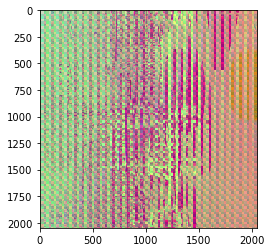

In [15]:
import random
r_img = random.choice(test_d)
p_img = torch.tensor(r_img[0]).permute(2,1,0) #0 for img, 1 for label
random_img = p_img.unsqueeze(0).permute(0,3,2,1).float() #to fake a batch-size for the model

with torch.no_grad():
    single_out = net(random_img)

upsampling_alg = nn.Upsample(size=2048*2048) #original image size
enhanced_image = upsampling_alg(single_out.reshape(1,1,20)) #1 batch, 1 channel, img*img long
enhanced_img = enhanced_image.reshape(2048,2048) #Collect into colour-arrays
enhanced_img = enhanced_img.squeeze() #squeeze batch
plt.imshow(enhanced_img)
plt.imshow(p_img)

